In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


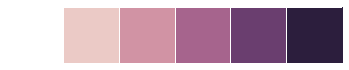

In [2]:
import seaborn as sns
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
sns.palplot(sns.cubehelix_palette(light=1))
import pandas as pd
pd.set_option('display.max_columns', 100)

In [3]:
nrows = 53
df = pd.read_csv('../data/cln_20150206_cary5000.csv')
df.set_index('wavelength', inplace=True)
df.columns

Index([u'Baseline 100%T', u'empty_1', u'empty_2_1', u'empty_2_2', u'empty_2_3', u'empty_2_4', u'empty_2_5', u'empty_2_6', u'empty_2_7', u'empty_2_8', u'empty_2_9', u'empty_2_10', u'empty_2_11', u'empty_2_12', u'empty_2_13', u'empty_2_14', u'empty_2_15', u'empty_3_1', u'empty_3_2', u'empty_3_3', u'empty_3_4', u'empty_3_5', u'VG05_1_1', u'VG05_1_2', u'VG05_1_3', u'VG05_1_4', u'VG05_1_5', u'Baseline 100%T.1', u'empty_4_1', u'empty_4_2', u'VG09-12_1_0', u'VG09-12_1_2', u'VG09-12_1_4', u'VG09-12_1_6', u'VG09-12_1_8', u'VG09-12_1_10', u'VG09-12_1_12', u'VG09-12_1_14', u'VG09-12_1_16', u'VG09-12_1_18', u'VG09-12_1_20', u'VG09-12_1_22', u'VG09-12_1_24', u'VG09-12_1_26', u'VG09-12_1_28', u'VG09-12_1_30', u'VG09-12_1_32', u'VG09-12_1_34', u'VG09-12_1_36', u'VG09-12_1_38', u'VG09-12_1_40', u'VG09-12_1_42', u'VG09-12_1_44', u'VG09-12_1_46', u'VG09-12_1_48', u'VG09-12_1_50', u'empty_5_1', u'empty_5_2', u'empty_5_3', u'empty_5_4', u'empty_5_5'], dtype='object')

In [4]:
log = pd.read_csv('../data/logDT_20150206_cary5000', names=['time'])
log.set_index(df.columns, inplace=True)
log['DT'] = pd.to_datetime(log.time)
log.head()

,time,DT
Baseline 100%T,2/6/2015 1:45:42 PM,2015-02-06 13:45:42
empty_1,2/6/2015 1:48:36 PM,2015-02-06 13:48:36
empty_2_1,2/6/2015 1:50:53 PM,2015-02-06 13:50:53
empty_2_2,2/6/2015 1:51:57 PM,2015-02-06 13:51:57
empty_2_3,2/6/2015 1:52:58 PM,2015-02-06 13:52:58


In [5]:
experiments = pd.concat([log['DT'], df.apply(np.mean, axis=0), df.apply(np.std, axis=0)], axis=1, copy=True)
experiments.columns=['time','mean', 'stddev']
df.drop('empty_4_2', inplace=True, axis=1)
experiments.drop('empty_4_2', inplace=True)

In [6]:
experiments.head()

,time,mean,stddev
Baseline 100%T,2015-02-06 13:45:42,0.108719,0.030123
empty_1,2015-02-06 13:48:36,0.995787,0.000618
empty_2_1,2015-02-06 13:50:53,0.992650,0.001644
empty_2_2,2015-02-06 13:51:57,0.990831,0.001585
empty_2_3,2015-02-06 13:52:58,0.990616,0.001257


Re-normalize everything after the second baseline.

In [7]:
baseline2_id = experiments.index.get_loc('Baseline 100%T.1')
ids = experiments.index[baseline2_id:]
rebaseline = experiments['mean'][baseline2_id]/experiments['mean'][0]
corr_experiments = experiments.copy()

corr_experiments['rebaseline'] = 1
corr_experiments['rebaseline'][ids] = rebaseline
corr_experiments['mean'][ids] = corr_experiments['mean'][ids]*rebaseline

-c:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
-c:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


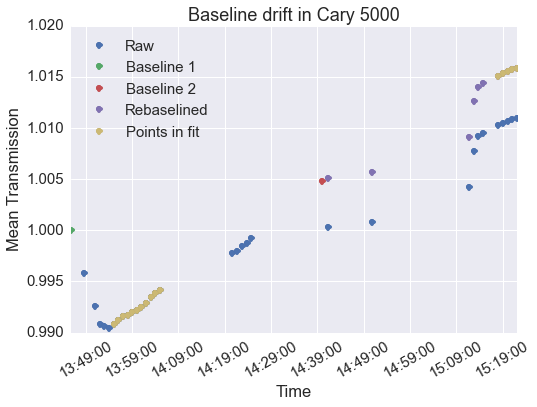

In [8]:
plt.plot_date(experiments.time, experiments['mean'], label='Raw')
plt.plot_date(experiments.loc['Baseline 100%T'].time,
              experiments.loc['Baseline 100%T']['mean']/experiments.loc['Baseline 100%T']['mean'],
              label='Baseline 1')
plt.plot_date(experiments.loc['Baseline 100%T.1'].time,
              experiments.loc['Baseline 100%T.1']['mean']/experiments.loc['Baseline 100%T']['mean'],
              label='Baseline 2')

plt.plot_date(experiments.time[ids],corr_experiments['mean'][ids], label='Rebaselined')

fit_inds = range(6,17) + range(55,60)
plt.plot_date(experiments.time[fit_inds],corr_experiments['mean'][fit_inds], label='Points in fit')


plt.legend(loc='best')
plt.xticks(rotation=30)
plt.ylim(0.99, 1.02)
plt.title('Baseline drift in Cary 5000')
plt.xlabel('Time')
plt.ylabel('Mean Transmission')


Run a linear model.

In [9]:
from astroML.linear_model import LinearRegression

In [10]:
X = corr_experiments['time'][fit_inds]
X = X.values.astype(np.float)
X_all = corr_experiments['time'].values.astype(np.float)
corr_experiments['time_num'] = X_all
y = corr_experiments['mean'][fit_inds].values
dy = corr_experiments['stddev'][fit_inds].values

In [11]:
model = LinearRegression()
model.fit(X[:, None], y, dy)

In [12]:
y_pred = model.predict(X_all[:, None])
corr_experiments['est_mean'] = y_pred

In [16]:
corr_experiments.head()

,time,mean,stddev,rebaseline,time_num,est_mean
Baseline 100%T,2015-02-06 13:45:42,0.108719,0.030123,1,1.423230e+18,0.988276
empty_1,2015-02-06 13:48:36,0.995787,0.000618,1,1.423231e+18,0.989113
empty_2_1,2015-02-06 13:50:53,0.992650,0.001644,1,1.423231e+18,0.989773
empty_2_2,2015-02-06 13:51:57,0.990831,0.001585,1,1.423231e+18,0.990081
empty_2_3,2015-02-06 13:52:58,0.990616,0.001257,1,1.423231e+18,0.990374


(0.98, 1.02)

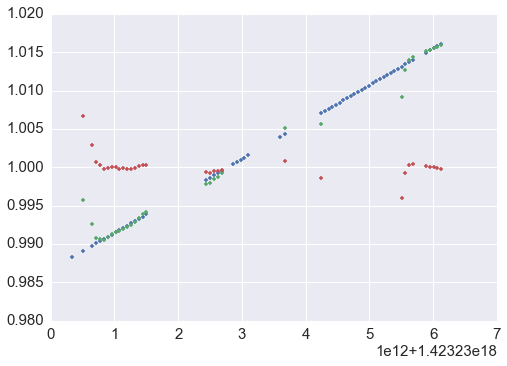

In [14]:
plt.plot(corr_experiments.time_num, corr_experiments['est_mean'], '.')
plt.plot(corr_experiments.time_num, corr_experiments['mean'], '.')

ratio = corr_experiments['mean']/corr_experiments['est_mean']

plt.plot(corr_experiments.time_num, ratio, '.')

plt.ylim(0.98, 1.02)

Divide everything by this new projected baseline.

In [17]:
corr_experiments.to_csv('../data/rebaseline_20150206_cary5000.csv')